In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1ma8zVet_KX6yCHKjYG91B8TTvwMLa7FS'
# file_id = '1fPhXTM4Plrp83QhZGbTqEt2aVOugYty0'
download = drive.CreateFile({'id': file_id})

# Download the file to a local disc
download.GetContentFile('file.csv')
df = pd.read_csv('file.csv')

***Active learning is a special case of machine learning where a learning algorithm can query a user or an oracle that can be a human annotator to label new data points with the desired outputs. It's particularly useful when labeling data is costly or time-consuming, and you want to train a model with as few labeled instances as possible while maintaining high performance.***

 **1**) **INITIAL TRAINING ON LABELED DATA**: Starts with a small amount of labeled data and train initial model. In this case a logistic regression, a simple yet effective machine learning model.

 **2**) **PREDICTING AND SELECTING UNLABELED DATA**: The model then looks at a pool of unlabeled data and makes predictions. Based on these predictions and certain criteria (like uncertainty or the probability outputs of the model), it selects certain instances to be labeled. This is the "active" part of active learning, where the model itself determines the most beneficial data points it wants to learn from next.

**ACTIVE LEARNING PART**: *The goal is to identify the samples about which the model is most uncertain. In the case of binary classification, this is often the samples for which the predicted probabilities are closest to 0.5 for both classes, meaning the model is essentially 'unsure' of their classification. This approach calculates uncertainty by measuring the absolute difference between the predicted probability of the 'real' class (assuming it's the first column, indexed by 0) and 0.5. The idea is to find the sample where this difference is the smallest, indicating the highest uncertainty. After identifying the most uncertain sample, you extract it from your pool of unlabeled data. This instance is what the model 'queries' or asks to be labeled, believing that understanding how to classify this particular sample correctly will provide the most significant insight into the classification task at hand.*

**3**) **QUERING THE "ORACLE"**: The selected instances are presented to the "oracle" (which could be a human expert) for labeling. The oracle provides the correct labels for these instances. In real-world scenarios, this is where the system would interact with an external entity capable of providing the labels. In the case of your code, this step is simulated as you already have the labels - they're just hidden from the model. "most_uncertain_sample_index = pool_indices [uncertainty_index]"

**4**) **RETRAINING THE MODEL**: The newly labeled instances are added back to the training set, and the model is retrained or updated based on this new, more informative dataset. The idea is that the model will perform better now that it has more relevant examples to learn from.

**5**) **ITERATION AND IMPROVEMENT**: Steps 2-4 are repeated for a number of iterations, gradually improving the model over time. Each iteration ideally provides the model with more informative examples, allowing it to make better and more nuanced decisions.


In [ ]:
df.head()

,text,target
0,ankara reuters turkish sudanese intelligence a...,Real
1,reuters supreme court friday refused stay ruli...,Real
2,one presidential candidate king dog whistle po...,Fake
3,wonder want anyone see speech singing praise t...,Fake
4,feel bern lot gullible young people fed big li...,Fake


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42998 entries, 0 to 42997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42998 non-null  object
 1   target  42998 non-null  object
dtypes: object(2)
memory usage: 672.0+ KB


In [ ]:
df['target'].value_counts()

Real    23362
Fake    19636
Name: target, dtype: int64

## TF-IDF Approach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer without setting max_features
vectorizer = TfidfVectorizer(stop_words='english')

# Apply the vectorizer on your text data
X = vectorizer.fit_transform(df['text'])

# Inspect the size of the resulting vocabulary
feature_names = vectorizer.get_feature_names_out()
num_features = len(feature_names)

print(f"Number of unique words (features) found: {num_features}")


Number of unique words (features) found: 108711


## Active Machine Learning w/ TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Preprocessing the text data with TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # parameters based on grid search results
# vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

# Encoding the 'target' with label encoding / Real=1, Fake=0
encoder = LabelEncoder()
y = encoder.fit_transform(df['target'])


#-----------------------------------------------------------------------------------------------------------------------

# # Initial setup - Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# # Split train set for pool sets
# X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, train_size=100, stratify=y_train, random_state=42)


# # Check the shapes of pooling datasets
# (X_initial.shape, X_pool.shape, y_initial.shape, y_pool.shape)


In [ ]:
# Initial split: training and temporary set | 60/40 split
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Split the temporary set into validation and test sets 40 is split into 20/20
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# prepare initial training set and the pool. The pool will contain the rest of the training data.
initial_train_size = 100  # or based on the size you want
X_initial, X_pool, y_initial, y_pool = train_test_split(X_train_temp, y_train_temp, train_size=initial_train_size, stratify=y_train_temp, random_state=42)

# To ensure the split was done correctly
print("Initial training set size:", len(y_initial))
print("Pool size:", len(y_pool))
print("Validation set size:", len(y_val))
print("Test set size:", len(y_test))

Initial training set size: 100
Pool size: 25698
Validation set size: 8600
Test set size: 8600


In [ ]:
# Check shape of test set
(X_test.shape, y_test.shape)

((8600, 5000), (8600,))

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.sparse import vstack, csr_matrix

# Initialize the model
# liblinear is chosen because it can handle both dense and sparse data
model = LogisticRegression(solver='liblinear')

# Number of queries we will make
N_QUERIES = 100

After query 1, validation accuracy: 0.61
After query 2, validation accuracy: 0.62
After query 3, validation accuracy: 0.63
After query 4, validation accuracy: 0.65
After query 5, validation accuracy: 0.64
After query 6, validation accuracy: 0.66
After query 7, validation accuracy: 0.68
After query 8, validation accuracy: 0.70
After query 9, validation accuracy: 0.72
After query 10, validation accuracy: 0.74
After query 11, validation accuracy: 0.76
After query 12, validation accuracy: 0.78
After query 13, validation accuracy: 0.79
After query 14, validation accuracy: 0.81
After query 15, validation accuracy: 0.83
After query 16, validation accuracy: 0.81
After query 17, validation accuracy: 0.83
After query 18, validation accuracy: 0.84
After query 19, validation accuracy: 0.85
After query 20, validation accuracy: 0.86
After query 21, validation accuracy: 0.88
After query 22, validation accuracy: 0.88
After query 23, validation accuracy: 0.89
After query 24, validation accuracy: 0.90
A

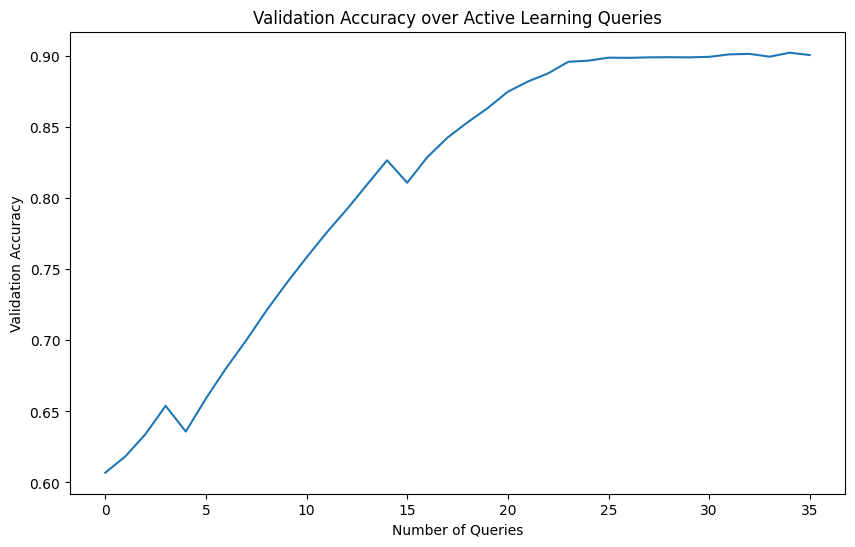

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Instead of splitting X and y into separate training and pool sets,
# we'll maintain a list of indices for the pool and access the samples through this list.
pool_indices = np.arange(X.shape[0])
np.random.shuffle(pool_indices)  # Shuffle the indices if needed

# Select the initial training set indices and remove them from the pool.
initial_training_indices = pool_indices[:100]  # Or any other criterion for initial selection
pool_indices = pool_indices[100:]

# 5 tries to improve its accuracy by 0.01, else it will stop
# Parameters for early stopping
patience = 10
tolerance = 0.01  # Minimum significant improvement / Validation accuracy
best_accuracy = 0.0
patience_counter = 0

performance_history = []

# These lists will hold the accuracy scores after each query
training_accuracies = []
validation_accuracies = []

# Active learning loop
for idx in range(N_QUERIES):
    # Train the model on the current training data
    model.fit(X[initial_training_indices], y[initial_training_indices])

    # Predict probabilities on the unlabeled pool
    probas = model.predict_proba(X[pool_indices])

    #------------------------------ IMPORTANT ----------------------------------
    # Calculate entropy for each sample; the most uncertain samples will have the highest entropy
    # Adding a small value inside the log for numerical stability
    entropy = -np.sum(probas * np.log(probas + 1e-10), axis=1)
    #---------------------------------------------------------------------------

    # Select the sample with the highest entropy (most uncertainty)
    uncertainty_index = np.argmax(entropy)

    # Get the actual index of the most uncertain sample from the pool
    most_uncertain_sample_index = pool_indices[uncertainty_index]

    # Remove the most uncertain sample index from the pool indices
    pool_indices = np.delete(pool_indices, uncertainty_index)

    # Add the index of the most uncertain sample to the training indices
    initial_training_indices = np.append(initial_training_indices, most_uncertain_sample_index)

    # Calculate training accuracy
    train_predictions = model.predict(X_initial)  # X_initial holds your current training data
    train_accuracy = accuracy_score(y_initial, train_predictions)  # y_initial holds the true labels
    training_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set and get the accuracy
    val_predictions = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    validation_accuracies.append(val_accuracy)
    performance_history.append(val_accuracy)

    print(f"After query {idx+1}, validation accuracy: {val_accuracy:.2f}")

    # Check if the current accuracy is the best we've seen so far
    if val_accuracy > best_accuracy + tolerance:
        best_accuracy = val_accuracy  # Update the best accuracy
        patience_counter = 0  # Reset the patience counter
    else:
        patience_counter += 1  # No improvement; increment the patience counter

    # If we have waited for 'patience' iterations without any significant improvement, stop the training.
    if patience_counter >= patience:
        print(f"No significant improvement for {patience} consecutive iterations. Stopping early.")
        break

# Here, you could add code to evaluate the final model on the test set and perhaps compare
# it with the performance of a model trained without active learning.

# Optionally, plot the validation accuracy history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(performance_history)
plt.xlabel('Number of Queries')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Active Learning Queries')
plt.show()


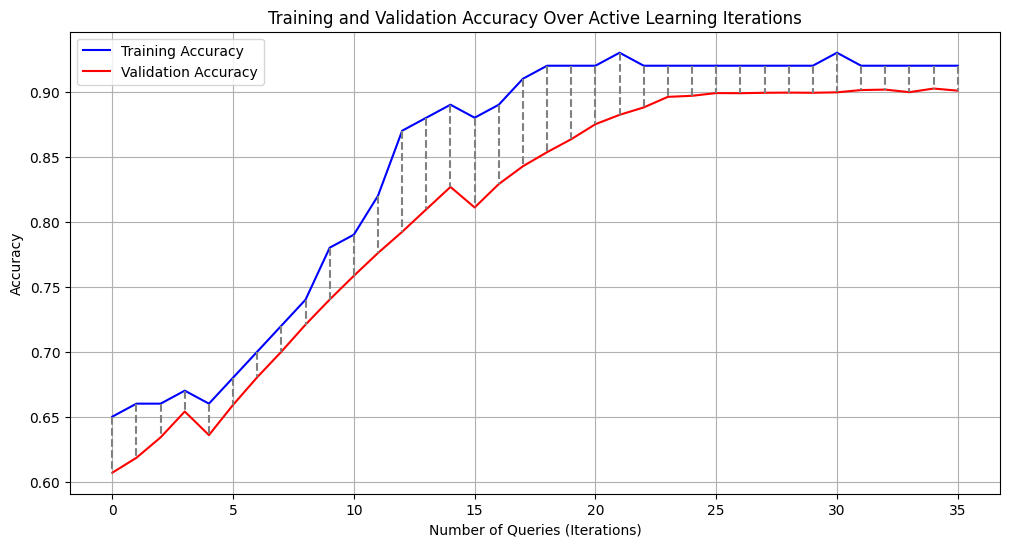

In [ ]:
# Now, let's plot the training and validation accuracy to visualize the learning progress
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.plot(training_accuracies, label='Training Accuracy', color='blue')
plt.plot(validation_accuracies, label='Validation Accuracy', color='red')

# Highlight the difference which might indicate overfitting
if len(training_accuracies) == len(validation_accuracies):
    for i in range(len(training_accuracies)):
        if training_accuracies[i] > validation_accuracies[i]:  # overfitting zone
            plt.plot([i, i], [training_accuracies[i], validation_accuracies[i]], color='grey', linestyle='--')

# Show legend
plt.legend()

# Maybe you want grid lines
plt.grid(True)

# Labels and title
plt.xlabel('Number of Queries (Iterations)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Active Learning Iterations')

# Show plot
plt.show()

In [ ]:
# Evaluation - After active learning process, evaluate the model on the test set
model.fit(X_initial, y_initial)
# Predictions on test data
predictions = model.predict(X_test)

# Performance metrics
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.64      0.74      3928
           1       0.76      0.93      0.83      4672

    accuracy                           0.80      8600
   macro avg       0.82      0.79      0.79      8600
weighted avg       0.81      0.80      0.79      8600

Confusion Matrix:
 [[2525 1403]
 [ 330 4342]]


## Active Learning Deep Learning Model

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from keras.optimizers import Adam
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
print(keras.__version__)

2.14.0


In [ ]:
# Convert labels to binary format
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [ ]:
df['target'].head()

0    1
1    1
2    0
3    0
4    0
Name: target, dtype: int64

In [ ]:
#Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(df[['text']], df['target'], test_size=0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = 42)

In [ ]:
X_train

,text
22049,oops mistake mistake one time understandable d...
36793,ankara reuters president tayyip erdogan dismis...
4220,scared death prospect donald trump president u...
2545,thank alabama protecting history good bad impo...
1482,whiskey tango hotel worry brooke clarified lud...
...,...
6265,sochi russia reuters critical decision taken s...
11284,beijing reuters china defended ally pakistan t...
38158,sydney reuters australian prime minister malco...
860,sean spicer former communication man republica...


In [ ]:
y_train

22049    0
36793    1
4220     0
2545     0
1482     0
        ..
6265     1
11284    1
38158    1
860      0
15795    0
Name: target, Length: 30098, dtype: int64

In [ ]:
# # to implement hybrid model
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# import gensim

# # Tokenize the text
# df['tokens'] = df['text'].apply(lambda x: x.split())

# # Train a Word2Vec model on your dataset
# word2vec_model = gensim.models.Word2Vec(df['tokens'], vector_size=300, window=5, min_count=1, sg=0)

In [ ]:
# ----------------- ---------------
import gensim.downloader as api

word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text'])
X_val_seq = tokenizer.texts_to_sequences(X_val['text'])

In [ ]:
# Pad the sequences
#max_length = max([len(x) for x in X_train_seq])  # You can set a custom length if needed
# max_length = 5000 # for compute efficiency

max_length = 500 # for compute efficiency
X_train = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # Assuming Word2Vec vectors are of size 300
for word, i in tokenizer.word_index.items():
    # if word in word2vec_model.wv:
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

# implement hybrid
def create_cnn_bi_lstm_model(input_length, embedding_matrix):
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Set trainable to False to keep the embeddings fixed
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
 #   model.add(Dropout(0.5)) # added this
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5)) # added this
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = create_cnn_bi_lstm_model(max_length, embedding_matrix)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          32686500  
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)          192128    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
pip install pydot graphviz

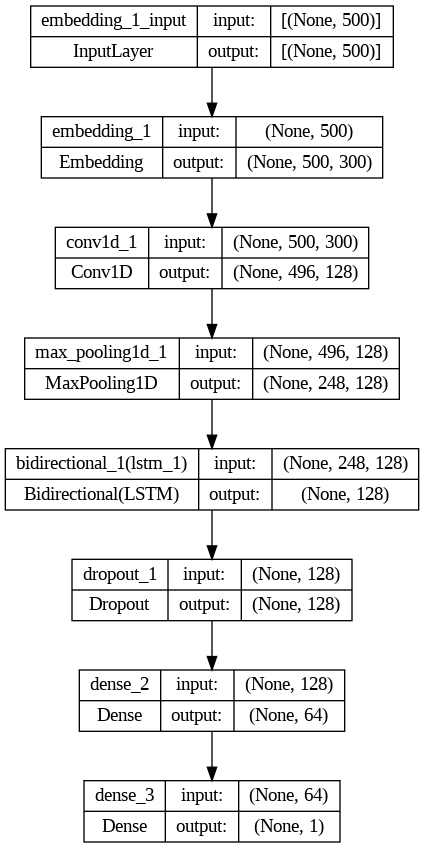

In [ ]:
import tensorflow as tf

# Assuming your model is named 'model'
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

to use hybrid

In [ ]:
X_val.shape

(6450, 500)

In [ ]:
y_val.shape

(6450,)

In [ ]:
X_val_1000 = X_val[:1000]
y_val_1000 = y_val[:1000]

In [ ]:
X_val_1000.shape

(1000, 500)

In [ ]:
y_val_1000.shape

(1000,)

In [ ]:
X_train.shape

(30098, 5000)

In [ ]:
# Initialize active learning parameters
N_QUERIES = 100
initial_train_size = 20  # starting size of the training set
patience = 10 # normally set to 5
tolerance = 0.01
best_accuracy = 0.0
patience_counter = 0
performance_history = []
training_accuracies = []
validation_accuracies = []

# Start with a small initial training set
initial_indices = np.random.choice(range(len(X_train)), size=initial_train_size, replace=False)

# Reset the index of y_train
y_train = y_train.reset_index(drop=True)  # not sure

# # Now you can use direct indexing
# X_initial = X_train[initial_indices]    # not sure
# y_initial = y_train[initial_indices]    # not sure


X_initial = X_train[initial_indices]
y_initial = y_train[initial_indices]

# The pool is the rest of the training data
pool_indices = np.setdiff1d(range(len(X_train)), initial_indices)

# Initialize the training set size counter
training_set_size = initial_train_size

# Active learning loop
for idx in range(N_QUERIES):
    print("The size of training data: " + str(len(X_initial)))
    print("The size of pool: " + str(len(X_train[pool_indices]) - 1))

    # Early stopping based on validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    # Fit the model to the current initial training data
    history = model.fit(X_initial, y_initial, validation_data=(X_val_1000, y_val_1000), callbacks=[early_stopping], epochs=10, batch_size=32) # normally 32
    # history = model.fit(X_initial, y_initial, validation_data=(X_val, y_val), epochs=10, batch_size=32)   # prior aproach
    #history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)  # Nghi code

    # Predict on the pool
    probas = model.predict(X_train[pool_indices], verbose=0)

    # Calculate entropy for each sample in the pool
    entropy = -np.sum(probas * np.log(probas + 1e-10), axis=1)

    # Select the sample with the highest entropy
    uncertainty_index = np.argmax(entropy)

    # Add the most uncertain sample to the initial training set
    X_initial = np.vstack((X_initial, X_train[pool_indices[uncertainty_index]]))
    y_initial = np.append(y_initial, y_train[pool_indices[uncertainty_index]])

    # Update the training set size counter
    training_set_size += 1

    # Remove the queried instance from the pool
    pool_indices = np.delete(pool_indices, uncertainty_index)

    # Get the last training accuracy
    train_accuracy = history.history['accuracy'][-1]
    training_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    # val_predictions = model.predict_classes(X_val)
    # val_accuracy = accuracy_score(y_val, val_predictions)
    # performance_history.append(val_accuracy)
    val_probas = model.predict(X_val)
    val_predictions = (val_probas > 0.5).astype("int32")
    val_accuracy = accuracy_score(y_val, val_predictions)
    performance_history.append(val_accuracy)

    # Early stopping based on validation accuracy
    if val_accuracy > best_accuracy + tolerance:
        best_accuracy = val_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"No improvement for {patience} consecutive iterations, stopping early.")
        break

    print(f"After query {idx + 1}: validation accuracy = {val_accuracy:.2f}, training set size = {training_set_size}")

The size of training data: 20
The size of pool: 30077
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.6944 - accuracy: 0.5500 - val_loss: 0.6838 - val_accuracy: 0.6590
Epoch 2/10
1/1 [==============================] - 0s 302ms/step - loss: 0.6528 - accuracy: 0.7500 - val_loss: 0.6722 - val_accuracy: 0.5610
Epoch 3/10
1/1 [==============================] - 0s 297ms/step - loss: 0.6261 - accuracy: 0.8500 - val_loss: 0.6578 - val_accuracy: 0.6860
Epoch 4/10
1/1 [==============================] - 0s 291ms/step - loss: 0.5576 - accuracy: 0.9500 - val_loss: 0.6418 - val_accuracy: 0.8260
Epoch 5/10
1/1 [==============================] - 0s 294ms/step - loss: 0.5314 - accuracy: 0.9500 - val_loss: 0.6221 - val_accuracy: 0.8550
Epoch 6/10
1/1 [==============================] - 0s 296ms/step - loss: 0.4840 - accuracy: 0.9000 - val_loss: 0.5956 - val_accuracy: 0.8550
Epoch 7/10
1/1 [==============================] - 0s 294ms/step - loss: 0.4560 - accuracy: 0.9000 - val_loss:

In [ ]:
X_test.shape

(6450, 500)

In [ ]:
# Final evaluation on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Final test set accuracy: {accuracy}, final training set size: {training_set_size}')

202/202 [==============================] - 2s 9ms/step - loss: 0.5045 - accuracy: 0.8667
Final test set accuracy: 0.8666666746139526, final training set size: 31


In [ ]:
test_probas = model.predict(X_test)
test_predictions = (test_probas > 0.5).astype("int32")

202/202 [==============================] - 2s 7ms/step


In [ ]:
report = classification_report(y_test, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2823
           1       0.88      0.88      0.88      3627

    accuracy                           0.87      6450
   macro avg       0.86      0.87      0.86      6450
weighted avg       0.87      0.87      0.87      6450



### Improve parameter of patience and tolerance for training

In [ ]:
def adjust_tolerance(query_num, initial_tolerance=0.02, reduction_factor=0.9, min_tolerance=0.005):
    """
    Adjust the tolerance dynamically based on the query number.
    - initial_tolerance: starting tolerance value
    - reduction_factor: factor by which tolerance is reduced
    - min_tolerance: minimum tolerance value to prevent it from getting too small
    """
    tolerance = initial_tolerance * (reduction_factor ** query_num)
    return max(tolerance, min_tolerance)


In [ ]:
# Initialize active learning parameters
N_QUERIES = 100
initial_train_size = 20
patience = 10
best_accuracy = 0.0
patience_counter = 0
training_set_size = initial_train_size


# N_QUERIES = 100
# initial_train_size = 50  # starting size of the training set
# patience = 5
# tolerance = 0.01
# best_accuracy = 0.0
# patience_counter = 0
performance_history = []
training_accuracies = []
validation_accuracies = []

# Start with a small initial training set
initial_indices = np.random.choice(range(len(X_train)), size=initial_train_size, replace=False)

# Reset the index of y_train
y_train = y_train.reset_index(drop=True)  # not sure

X_initial = X_train[initial_indices]
y_initial = y_train[initial_indices]

# The pool is the rest of the training data
pool_indices = np.setdiff1d(range(len(X_train)), initial_indices)

# Initialize the training set size counter
training_set_size = initial_train_size

# Active learning loop
for idx in range(N_QUERIES):

    current_tolerance = adjust_tolerance(idx)
    print("Query number:", idx + 1, "Tolerance:", current_tolerance)

    print("The size of training data: " + str(len(X_initial)))

    # Early stopping based on validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    # Fit the model to the current initial training data
    history = model.fit(X_initial, y_initial, validation_data=(X_val_1000, y_val_1000), callbacks=[early_stopping], epochs=10, batch_size=64)
    # history = model.fit(X_initial, y_initial, validation_data=(X_val, y_val), epochs=10, batch_size=32)   # prior aproach
    #history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)  # Nghi code

    # Predict on the pool
    probas = model.predict(X_train[pool_indices], verbose=0)

    # Calculate entropy for each sample in the pool
    entropy = -np.sum(probas * np.log(probas + 1e-10), axis=1)

    # Select the sample with the highest entropy
    uncertainty_index = np.argmax(entropy)

    # Add the most uncertain sample to the initial training set
    X_initial = np.vstack((X_initial, X_train[pool_indices[uncertainty_index]]))
    y_initial = np.append(y_initial, y_train[pool_indices[uncertainty_index]])

    # Update the training set size counter
    training_set_size += 1

    # Remove the queried instance from the pool
    pool_indices = np.delete(pool_indices, uncertainty_index)

    # Get the last training accuracy
    train_accuracy = history.history['accuracy'][-1]
    training_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    # val_predictions = model.predict_classes(X_val)
    # val_accuracy = accuracy_score(y_val, val_predictions)
    # performance_history.append(val_accuracy)
    val_probas = model.predict(X_val)
    val_predictions = (val_probas > 0.5).astype("int32")
    val_accuracy = accuracy_score(y_val, val_predictions)
    performance_history.append(val_accuracy)

    # # Early stopping based on validation accuracy
    # if val_accuracy > best_accuracy + tolerance:
    #     best_accuracy = val_accuracy
    #     patience_counter = 0
    # else:
    #     patience_counter += 1

    # if patience_counter >= patience:
    #     print(f"No improvement for {patience} consecutive iterations, stopping early.")
    #     break

    # print(f"After query {idx + 1}: validation accuracy = {val_accuracy:.2f}, training set size = {training_set_size}")


    # Early stopping and performance tracking logic
    if val_accuracy > best_accuracy + current_tolerance:
        best_accuracy = val_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"No improvement for {patience} consecutive iterations, stopping early.")
        break

    print(f"After query {idx + 1}: validation accuracy = {val_accuracy:.2f}, training set size = {training_set_size}")

Query number: 1 Tolerance: 0.02
The size of training data: 20
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.6271 - accuracy: 0.8000 - val_loss: 0.6809 - val_accuracy: 0.5150
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.5158 - accuracy: 0.8000 - val_loss: 0.6716 - val_accuracy: 0.5150
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.4608 - accuracy: 0.7500 - val_loss: 0.6728 - val_accuracy: 0.5150
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.3504 - accuracy: 0.9500 - val_loss: 0.6833 - val_accuracy: 0.5150
Epoch 5/10
202/202 [==============================] - 15s 75ms/step
After query 1: validation accuracy = 0.55, training set size = 21
Query number: 2 Tolerance: 0.018000000000000002
The size of training data: 21
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.3402 - accuracy: 0.8095 - val_loss: 0.6798 - val_accuracy: 0.5170
Epoch 2/10
1/1 [=========================

In [ ]:
test_probas = model.predict(X_test)
test_predictions = (test_probas > 0.5).astype("int32")

202/202 [==============================] - 15s 75ms/step


In [ ]:
report = classification_report(y_test, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.99      0.94      2823
           1       1.00      0.90      0.94      3627

    accuracy                           0.94      6450
   macro avg       0.94      0.95      0.94      6450
weighted avg       0.95      0.94      0.94      6450



### Hyperparameter Testing

In [ ]:
def train_model(learning_rate, batch_size, X_train, y_train, X_val, y_val, epochs=5):
    # Create and compile the model (use your existing model architecture)
    model = create_cnn_bi_lstm_model(max_length, embedding_matrix)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    # Extract performance metrics
    val_accuracy = max(history.history['val_accuracy'])

    return val_accuracy, model


In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

best_accuracy = 0
best_lr = None
best_batch_size = None

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with learning rate: {lr}, batch size: {batch_size}")
        val_accuracy, _ = train_model(lr, batch_size, X_train, y_train, X_val, y_val)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_lr = lr
            best_batch_size = batch_size

        print(f"Validation Accuracy: {val_accuracy}")

print(f"Best Accuracy: {best_accuracy} with Learning Rate: {best_lr} and Batch Size: {best_batch_size}")


Training with learning rate: 0.001, batch size: 32
Epoch 1/5
941/941 [==============================] - 182s 189ms/step - loss: 0.0990 - accuracy: 0.9645 - val_loss: 0.0523 - val_accuracy: 0.9788
Epoch 2/5
941/941 [==============================] - 181s 193ms/step - loss: 0.0467 - accuracy: 0.9830 - val_loss: 0.0431 - val_accuracy: 0.9847
Epoch 3/5
941/941 [==============================] - 187s 199ms/step - loss: 0.0313 - accuracy: 0.9890 - val_loss: 0.0529 - val_accuracy: 0.9817
Epoch 4/5
941/941 [==============================] - 183s 194ms/step - loss: 0.0214 - accuracy: 0.9930 - val_loss: 0.0438 - val_accuracy: 0.9833
Epoch 5/5
941/941 [==============================] - 182s 194ms/step - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.0556 - val_accuracy: 0.9834
Validation Accuracy: 0.9846511483192444
Training with learning rate: 0.001, batch size: 64
Epoch 1/5
471/471 [==============================] - 128s 260ms/step - loss: 0.1220 - accuracy: 0.9560 - val_loss: 0.0594 - val_accur

## For loop for 30 iterations

In [ ]:
accuracies = []
training_sizes = []

for run in range(30):
    print(f"Run {run + 1} with random_state {42 + run}")

    # Split the data with the new random_state
    X_train, X_temp, y_train, y_temp = train_test_split(df[['text']], df['target'], test_size=0.3, random_state=42 + run)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42 + run)

    # The rest of your code goes here...
    # Make sure to include tokenizer, padding, model creation, and active learning loop
    #-----------------------------------------------------------------------------------------------------------------
    # Tokenize the text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['text'])
    X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
    X_test_seq = tokenizer.texts_to_sequences(X_test['text'])
    X_val_seq = tokenizer.texts_to_sequences(X_val['text'])

    max_length = 500 # for compute efficiency
    X_train = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
    X_test = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
    X_val = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # Assuming Word2Vec vectors are of size 300
    for word, i in tokenizer.word_index.items():
        # if word in word2vec_model.wv:
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    # Create model
    model = create_cnn_bi_lstm_model(max_length, embedding_matrix)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.summary()

    # Set validation set
    X_val_1000 = X_val[:1000]
    y_val_1000 = y_val[:1000]

    # Active learning loop
    # Initialize active learning parameters
    N_QUERIES = 100
    initial_train_size = 20  # starting size of the training set
    patience = 10 # normally set to 5
    tolerance = 0.01
    best_accuracy = 0.0
    patience_counter = 0
    performance_history = []
    training_accuracies = []
    validation_accuracies = []

    # Start with a small initial training set
    initial_indices = np.random.choice(range(len(X_train)), size=initial_train_size, replace=False)

    # Reset the index of y_train
    y_train = y_train.reset_index(drop=True)  # not sure

    # # Now you can use direct indexing
    # X_initial = X_train[initial_indices]    # not sure
    # y_initial = y_train[initial_indices]    # not sure


    X_initial = X_train[initial_indices]
    y_initial = y_train[initial_indices]

    # The pool is the rest of the training data
    pool_indices = np.setdiff1d(range(len(X_train)), initial_indices)

    # Initialize the training set size counter
    training_set_size = initial_train_size

    # Active learning loop
    for idx in range(N_QUERIES):
        print("The size of training data: " + str(len(X_initial)))
        print("The size of pool: " + str(len(X_train[pool_indices]) - 1))

        # Early stopping based on validation loss
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)

        # Fit the model to the current initial training data
        history = model.fit(X_initial, y_initial, validation_data=(X_val_1000, y_val_1000), callbacks=[early_stopping], epochs=10, batch_size=32) # normally 32
        # history = model.fit(X_initial, y_initial, validation_data=(X_val, y_val), epochs=10, batch_size=32)   # prior aproach
        #history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)  # Nghi code

        # Predict on the pool
        probas = model.predict(X_train[pool_indices], verbose=0)

        # Calculate entropy for each sample in the pool
        entropy = -np.sum(probas * np.log(probas + 1e-10), axis=1)

        # Select the sample with the highest entropy
        uncertainty_index = np.argmax(entropy)

        # Add the most uncertain sample to the initial training set
        X_initial = np.vstack((X_initial, X_train[pool_indices[uncertainty_index]]))
        y_initial = np.append(y_initial, y_train[pool_indices[uncertainty_index]])

        # Update the training set size counter
        training_set_size += 1

        # Remove the queried instance from the pool
        pool_indices = np.delete(pool_indices, uncertainty_index)

        # Get the last training accuracy
        train_accuracy = history.history['accuracy'][-1]
        training_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        # val_predictions = model.predict_classes(X_val)
        # val_accuracy = accuracy_score(y_val, val_predictions)
        # performance_history.append(val_accuracy)
        val_probas = model.predict(X_val)
        val_predictions = (val_probas > 0.5).astype("int32")
        val_accuracy = accuracy_score(y_val, val_predictions)
        performance_history.append(val_accuracy)

        # Early stopping based on validation accuracy
        if val_accuracy > best_accuracy + tolerance:
            best_accuracy = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"No improvement for {patience} consecutive iterations, stopping early.")
            break

        print(f"After query {idx + 1}: validation accuracy = {val_accuracy:.2f}, training set size = {training_set_size}")


    #----------------------------------------------------------------------------------------------------------------
    # After the active learning loop, evaluate on the test set and print the classification report
    test_probas = model.predict(X_test)
    test_predictions = (test_probas > 0.5).astype("int32")
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Append the final accuracy and training set size
    accuracies.append(test_accuracy)
    training_sizes.append(len(X_initial))


    print(classification_report(y_test, test_predictions))

    # Print the final training set size
    print(f"Final training set size: {len(X_initial)}\n")

Streaming output truncated to the last 5000 lines.
The size of training data: 25
The size of pool: 30072
Epoch 1/10
1/1 [==============================] - 0s 336ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.7713 - val_accuracy: 0.6820
Epoch 2/10
1/1 [==============================] - 0s 300ms/step - loss: 0.0905 - accuracy: 0.9600 - val_loss: 0.7898 - val_accuracy: 0.6650
Epoch 3/10
1/1 [==============================] - 0s 296ms/step - loss: 0.1671 - accuracy: 0.9200 - val_loss: 0.6971 - val_accuracy: 0.7050
Epoch 4/10
1/1 [==============================] - 0s 297ms/step - loss: 0.0565 - accuracy: 1.0000 - val_loss: 0.5775 - val_accuracy: 0.7490
Epoch 5/10
1/1 [==============================] - 0s 298ms/step - loss: 0.0785 - accuracy: 0.9600 - val_loss: 0.4498 - val_accuracy: 0.8150
Epoch 6/10
1/1 [==============================] - 0s 310ms/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.3589 - val_accuracy: 0.8410
Epoch 7/10
1/1 [==============================] - 0s 30

In [ ]:
accuracies

[0.8049612403100775,
 0.8683720930232558,
 0.8181395348837209,
 0.8409302325581396,
 0.924186046511628,
 0.8984496124031007,
 0.8472868217054264,
 0.8412403100775194,
 0.9041860465116279,
 0.8314728682170542,
 0.8937984496124031,
 0.8967441860465116,
 0.8427906976744186,
 0.8590697674418605,
 0.7868217054263565,
 0.7837209302325582,
 0.7711627906976745,
 0.8582945736434109,
 0.9091472868217054,
 0.7913178294573643,
 0.8265116279069767,
 0.7978294573643411,
 0.8632558139534884,
 0.8562790697674418,
 0.8813953488372093,
 0.813953488372093,
 0.8886821705426357,
 0.8872868217054264,
 0.88,
 0.9337984496124031]

In [ ]:
training_sizes

[44,
 31,
 38,
 38,
 64,
 52,
 31,
 37,
 58,
 41,
 56,
 61,
 36,
 32,
 40,
 41,
 37,
 36,
 73,
 31,
 44,
 34,
 31,
 31,
 36,
 31,
 34,
 62,
 36,
 68]

In [ ]:
# 10 iterations

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_training_size = np.mean(training_sizes)
std_training_size = np.std(training_sizes)

print(f"Initial Training Set Size: 20")
print(f"Mean Accuracy: {mean_accuracy:.4f}, Standard Deviation: {std_accuracy:.4f}")
print(f"Mean Training Set Size: {mean_training_size:.4f}, Standard Deviation: {std_training_size:.4f}")

Initial Training Set Size: 20
Mean Accuracy: 0.8250, Standard Deviation: 0.0624
Mean Training Set Size: 43.8000, Standard Deviation: 8.9644


In [ ]:
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_training_size = np.mean(training_sizes)
std_training_size = np.std(training_sizes)

print(f"Initial Training Set Size: 20")
print(f"Mean Accuracy: {mean_accuracy:.4f}, Standard Deviation: {std_accuracy:.4f}")
print(f"Mean Training Set Size: {mean_training_size:.4f}, Standard Deviation: {std_training_size:.4f}")

Initial Training Set Size: 20
Mean Accuracy: 0.8534, Standard Deviation: 0.0435
Mean Training Set Size: 42.8000, Standard Deviation: 12.3946


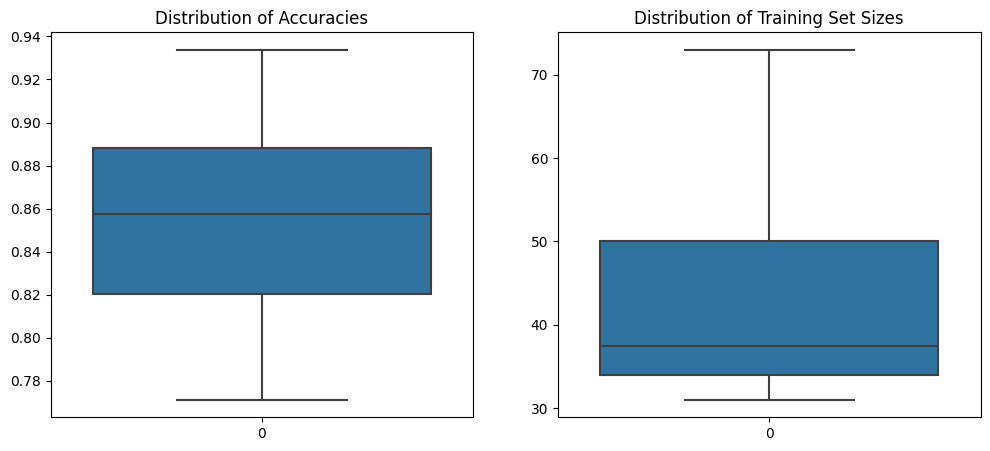

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=accuracies)
plt.title('Distribution of Accuracies')

plt.subplot(1, 2, 2)
sns.boxplot(data=training_sizes)
plt.title('Distribution of Training Set Sizes')

plt.show()

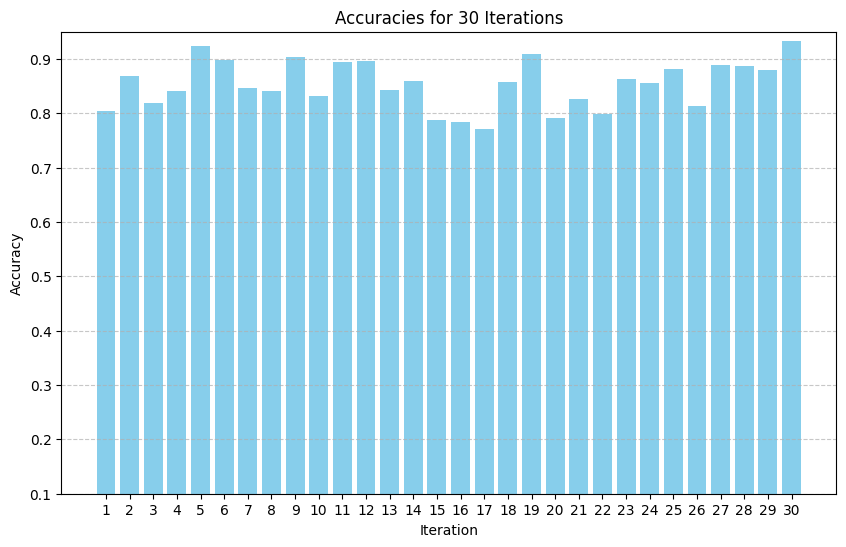

In [ ]:
# Bar plot for accuracies
plt.figure(figsize=(10, 6))
plt.bar(range(1, 31), accuracies, color='skyblue')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracies for 30 Iterations')
plt.xticks(range(1, 31))  # Setting x-axis labels as iteration numbers
plt.ylim([0.1, 0.95])  # Adjusting y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding a grid for readability
plt.show()